In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import shap
from sklearn.calibration import CalibratedClassifierCV

C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 2. Load and clean dataset
df = pd.read_csv("Extended_Employee_Performance_and_Productivity_Data.csv")
df = df[df['Age'] - df['Years_At_Company'] >= 18]  # Logical fix: cannot have started work before 18
df['Promotions'] = df[['Promotions', 'Years_At_Company']].min(axis=1)  # Promotions <= Years_At_Company
df['Hire_Date'] = pd.to_datetime(df['Hire_Date'])

In [3]:
# 3. Outlier Removal
def remove_outliers_iqr(df, columns):
    """
    Removes rows with outlier values (outside 1.5*IQR) for each specified numerical column.
    Keeps modeling robust and prevents model skew.
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

numerical_cols = ['Age', 'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled',
                  'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size',
                  'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score', 'Performance_Score']
df = remove_outliers_iqr(df, numerical_cols)

In [4]:
# 4. Feature Engineering
df['Tenure_Months'] = ((pd.Timestamp.today() - df['Hire_Date']) / pd.Timedelta(days=30)).astype(int)
df_encoded = pd.get_dummies(df, columns=['Department', 'Gender', 'Job_Title'], drop_first=True)
education_order = {'High School': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4}
df_encoded['Education_Level'] = df_encoded['Education_Level'].map(education_order)
df_encoded.drop(['Employee_ID', 'Hire_Date'], axis=1, inplace=True)
df_encoded['Projects_per_Year'] = df_encoded['Projects_Handled'] / df_encoded['Years_At_Company'].replace(0, 1)
df_encoded['Overtime_per_Week'] = df_encoded['Overtime_Hours'] / 52
df_encoded['Engagement_Index'] = (
    df_encoded['Performance_Score'] + 
    df_encoded['Employee_Satisfaction_Score'] + 
    df_encoded['Promotions']
) / 3

In [5]:
# Advanced features
df_encoded['Engagement_Delta'] = df_encoded['Promotions'] / df_encoded['Years_At_Company'].replace(0, 1)
if 'Department_HR' in df_encoded.columns:
    dept_salary_mean = df_encoded.groupby('Department_HR')['Monthly_Salary'].transform('mean')
else:
    dept_salary_mean = df_encoded['Monthly_Salary'].mean()
df_encoded['Is_Underpaid'] = (df_encoded['Monthly_Salary'] < dept_salary_mean).astype(int)
df_encoded['Burnout_Risk'] = df_encoded['Overtime_per_Week'] * df_encoded['Sick_Days']


In [6]:
# 5. Train/Test Split
X = df_encoded.drop('Resigned', axis=1)
y = df_encoded['Resigned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# 6. SMOTE Balancing
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kadar\anaconda3\envs\dataeng\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kadar\anaconda3\envs\dataeng\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kadar\anaconda3\envs\dataeng\Lib\subprocess.py", line

In [8]:
# 7. XGBoost Model
scale = (len(y_resampled) - sum(y_resampled)) / sum(y_resampled)
model_xgb = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_xgb.fit(X_resampled, y_resampled)


C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [9]:
# 8. Threshold Tuning & Evaluation
y_proba = model_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)
print("\n📊 Final Model Evaluation (Threshold = 0.25):")
print(classification_report(y_test, y_pred))



📊 Final Model Evaluation (Threshold = 0.25):
              precision    recall  f1-score   support

       False       0.90      0.77      0.83     17315
        True       0.11      0.26      0.16      1929

    accuracy                           0.72     19244
   macro avg       0.51      0.51      0.49     19244
weighted avg       0.82      0.72      0.76     19244



In [10]:
# 9. Save Model & Export At-Risk Employees
joblib.dump(model_xgb, "resignation_predictor_model.pkl")
X_test_copy = X_test.copy()
X_test_copy['Resigned_Prob'] = y_proba
X_test_copy['Predicted_Resigned'] = y_pred
top_100 = X_test_copy.sort_values(by='Resigned_Prob', ascending=False).head(100)
top_100.to_csv("high_risk_employees.csv", index=False)


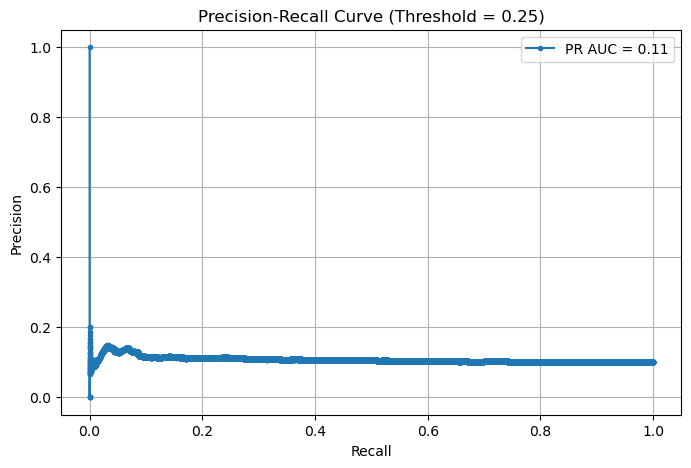

In [11]:
# 10. PR Curve (XGBoost)
# ---- Block use: Shows trade-off between precision and recall for different thresholds on XGBoost predictions.
# ---- Why: PR curve is more informative than ROC-AUC for highly imbalanced datasets.
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(8, 5))
plt.plot(recall_vals, precision_vals, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Threshold = 0.25)')
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_curve.png")
plt.show()

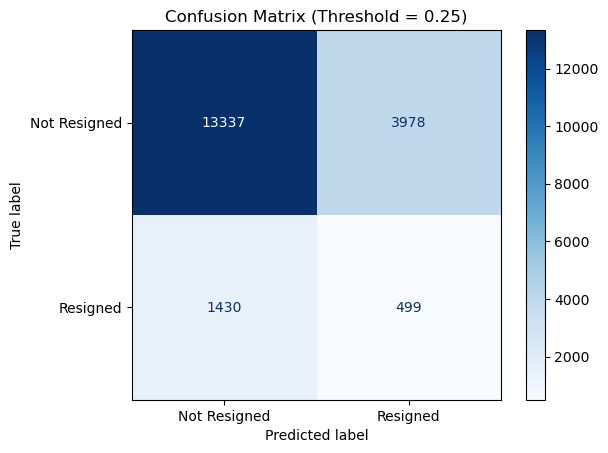

In [12]:
# 11. Confusion Matrix
# ---- Block use: Visualizes true positives, false positives, true negatives, and false negatives for thresholded predictions.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Not Resigned", "Resigned"], cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.25)")
plt.savefig("confusion_matrix_threshold_025.png")
plt.show()


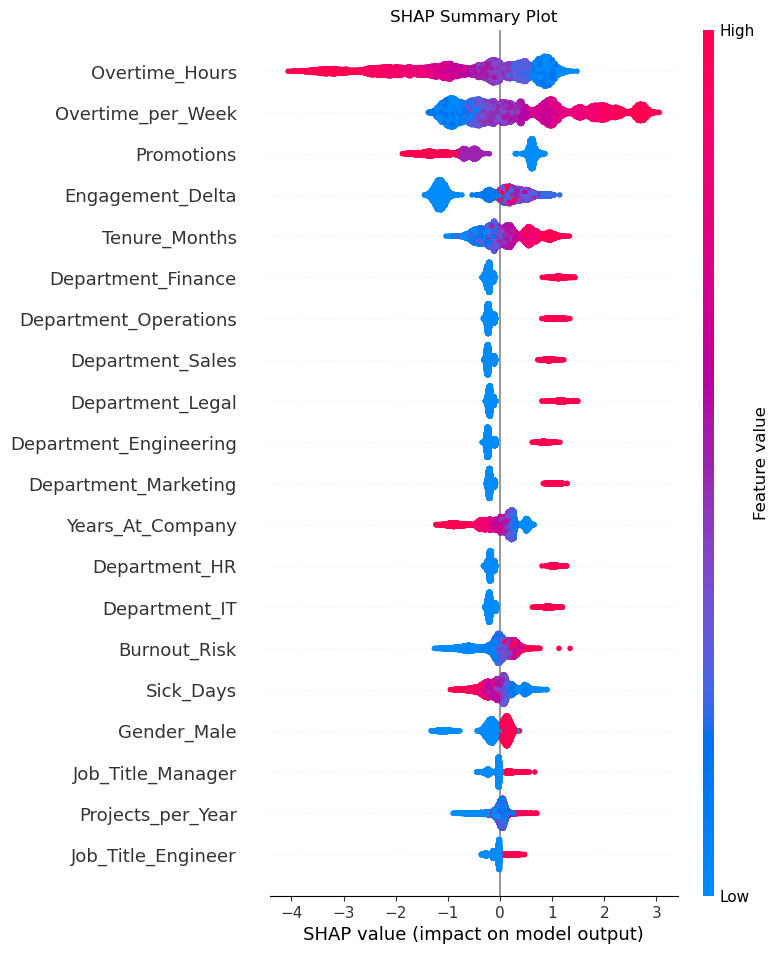

In [13]:
# 12. SHAP Summary Plot
# ---- Block use: Visualizes which features contribute most to the model’s predictions (model explainability).
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot")
plt.savefig("shap_summary_plot.png")
plt.show()

In [14]:
# 13. CalibratedClassifierCV (Optional but recommended for deployment)
# ---- Block use: Calibrates XGBoost probabilities using StratifiedKFold CV for more reliable risk prediction.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
calibrated_model = CalibratedClassifierCV(model_xgb, cv=skf)
calibrated_model.fit(X_resampled, y_resampled)
y_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
y_pred_calibrated = (y_proba_calibrated >= 0.25).astype(int)

C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kadar\anaconda3\envs\dataeng\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

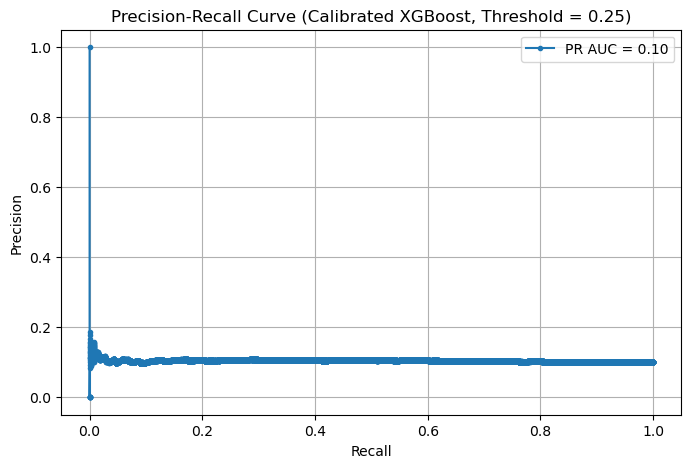

In [15]:
# 14. PR Curve (Calibrated)
# ---- Block use: Shows PR curve of the calibrated model. Calibrated probabilities often improve precision/recall trade-off.
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_calibrated)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(8, 5))
plt.plot(recall_vals, precision_vals, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Calibrated XGBoost, Threshold = 0.25)')
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_curve_calibrated.png")
plt.show()